v01: Switch to DWAQ output which has all of the POTWs, regenerate outputs.

In [12]:
from __future__ import print_function

In [1]:
%matplotlib notebook
import os
import wkb2shp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import qnc
import plot_wkb
from shapely import geometry
import plot_utils
import ugrid
import pandas as pd
import utils
import gmtColormap

/home/rusty/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [23]:
version='v01' # version of the output - should match this file

In [20]:
region_shp='tally_regions_v00.shp'
regions=wkb2shp.shp2geom(region_shp)
# regions[0]['geom']

In [4]:
base_dir='/home/rusty/models/delft/nbwaq/spinupdate/dwaqD02cons' 
nc_fn=os.path.join(base_dir,'spinup_dwaq00_out.nc')
nc=qnc.QDataset(nc_fn)
ug=ugrid.Ugrid(nc) 
g=ug.grid()

<IPython.core.display.Javascript object>


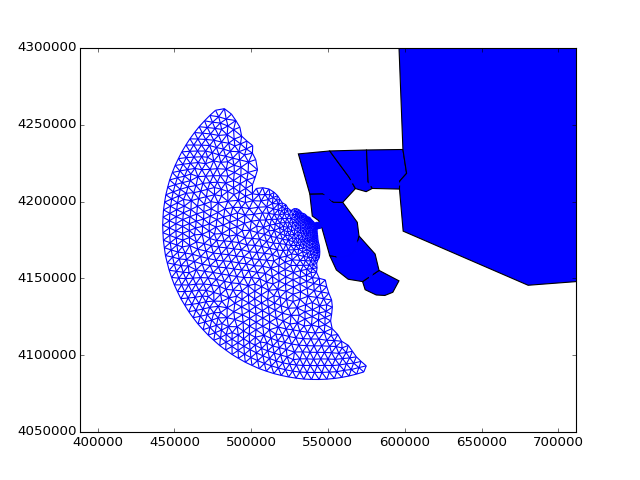

In [5]:
plt.figure()
g.plot_edges()
for poly in regions['geom']:
    plot_wkb.plot_polygon(poly)

In [6]:
# select cells for each region:
# choose based on center of each cell to avoid double-counting
vc=g.cells_center()
vcp=[geometry.Point(p) for p in vc]
cell_regions=np.zeros(g.Ncells(),'i4')-1

for region_i in range(len(regions)):
    poly=regions['geom'][region_i]
    in_poly=np.array([poly.contains(p) for p in vcp],'b1')
    cell_regions[in_poly]=region_i
    print "%s => %d cells"%( regions['name'][region_i], np.sum(in_poly))


lower south bay => 1373 cells
south bay => 7451 cells
central bay => 9485 cells
san pablo bay => 2468 cells
carquinez => 198 cells
suisun bay => 904 cells
delta => 1707 cells


<IPython.core.display.Javascript object>


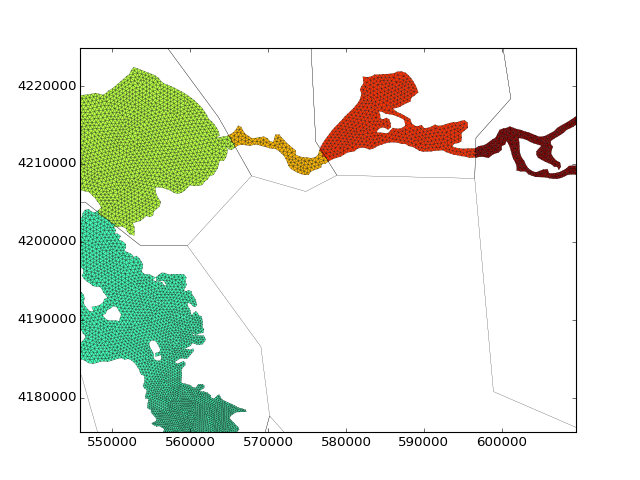

(400000.0, 750000.0, 4050000.0, 4350000.0)

In [7]:
plt.figure()
g.plot_cells(values=cell_regions,lw=0.2)
for poly in regions['geom']:
    plot_wkb.plot_polygon(poly,fc='none',ec='k',lw=0.2)
plt.axis('equal')

In [8]:
nc._dump()

netcdf4 unknown_filename {
dimensions:
    nFlowElem = 25261 ;
    nFlowElemContourPts = 3 ;
    nFlowLink = 36963 ;
    nFlowLinkPts = 2 ;
    nNode = 13728 ;
    nFlowEdge = 38991 ;
    nEdgePts = 2 ;
    nFlowMesh_layers = 31 ;
    nFlowMesh_layers2 = 31 ;
    d2 = 2 ;
    d1 = 1 ;
    d4 = 4 ;
    d46 = 46 ;
    d6 = 6 ;
    d7 = 7 ;
    time = 840 ;
variables:
    float64 FlowElem_xcc(nFlowElem) ;
         FlowElem_xcc:units = m
         FlowElem_xcc:long_name = Flow element centroid x
         FlowElem_xcc:standard_name = projection_x_coordinate
         FlowElem_xcc:grid_mapping = projected_coordinate_system
         FlowElem_xcc:bounds = FlowElemContour_x
    float64 FlowElem_ycc(nFlowElem) ;
         FlowElem_ycc:units = m
         FlowElem_ycc:long_name = Flow element centroid y
         FlowElem_ycc:standard_name = projection_y_coordinate
         FlowElem_ycc:grid_mapping = projected_coordinate_system
         FlowElem_ycc:bounds = FlowElemContour_y
    float32 FlowElem_zcc

In [13]:
scalars=[]
skip=['localdepth','surf','totaldepth','depth','volume']
for v in nc.variables:
    if v not in skip and nc[v].dims == ('time','nFlowElem','nFlowMesh_layers'):
        scalars.append(v)
print("Will create output for %d tracers"%len(scalars))

Will create output for 41 tracers


In [15]:
# Tally the mass contribution of one POTW to one region at one timestep:

times_dt64=utils.to_dt64(nc.time.as_datenum())

# little faster than scanning bitmask
cell_region_idxs=[np.nonzero(cell_regions==ri)[0]
                  for ri in range(len(regions))]

time_range=[np.datetime64('2013-06-01 00:00'),
            np.datetime64('2013-09-01 00:00')]
ti_start,ti_stop=np.searchsorted(times_dt64,time_range)
recs=[]
for ti in range(ti_start,ti_stop):
    print(times_dt64[ti],end=" ")
    for si in range(len(scalars)):
        print(scalars[si][:5],end=' ')
        # integrate water columns first
        scal=nc.variables[scalars[si]]
        conc_global=scal[ti,:,:]
        vols=nc.volume[ti,:,:] # masked below the bed, but 1.0 above the freesurface
        vols.mask |= vols<=1.0 # now masked above the freesurface

        mass_2d=(conc_global*vols).sum(axis=1)
        water_2d=vols.sum(axis=1)
        for ri in range(len(regions)):
            cells=cell_region_idxs[ri]
            mass_region=mass_2d[cells].sum()
            water_region=water_2d[cells].sum()
            recs.append(dict(region_i=ri,region_name=regions['name'][ri],
                             time=times_dt64[ti],
                             tracer=scalars[si],mass=mass_region,water=water_region))
    print()
df=pd.DataFrame(recs)

2013-06-01T05:00:00.000000000-0700 san_j palo_ sunny sf_so centr south san_m south ameri benic burli calis centr c&h,_ delta ebda ebmud fairf las_g sasm marin millb mt._v napa novat petal pinol rodeo sausa sfo sonom st._h treas valle west_ yount chevr phill shell tesor valer 
2013-06-01T17:00:00.000000000-0700 san_j palo_ sunny sf_so centr south san_m south ameri benic burli calis centr c&h,_ delta ebda ebmud fairf las_g sasm marin millb mt._v napa novat petal pinol rodeo sausa sfo sonom st._h treas valle west_ yount chevr phill shell tesor valer 
2013-06-02T05:00:00.000000000-0700 san_j palo_ sunny sf_so centr south san_m south ameri benic burli calis centr c&h,_ delta ebda ebmud fairf las_g sasm marin millb mt._v napa novat petal pinol rodeo sausa sfo sonom st._h treas valle west_ yount chevr phill shell tesor valer 
2013-06-02T17:00:00.000000000-0700 san_j palo_ sunny sf_so centr south san_m south ameri benic burli calis centr c&h,_ delta ebda ebmud fairf las_g sasm marin millb mt._

In [16]:
df.head(30)

,mass,region_i,region_name,time,tracer,water
0,4427711.000000,0,lower south bay,2013-06-01 12:00:00,san_jose_wwtp,78287064
1,9719739.000000,1,south bay,2013-06-01 12:00:00,san_jose_wwtp,890624832
2,9408838.000000,2,central bay,2013-06-01 12:00:00,san_jose_wwtp,4658191872
3,1014471.625000,3,san pablo bay,2013-06-01 12:00:00,san_jose_wwtp,1137540352
4,161017.437500,4,carquinez,2013-06-01 12:00:00,san_jose_wwtp,309243264
5,104195.765625,5,suisun bay,2013-06-01 12:00:00,san_jose_wwtp,518373760
6,10720.279297,6,delta,2013-06-01 12:00:00,san_jose_wwtp,1427596800
7,704753.625000,0,lower south bay,2013-06-01 12:00:00,palo_alto_wwtp,78287064
8,2281409.000000,1,south bay,2013-06-01 12:00:00,palo_alto_wwtp,890624832
9,2030040.125000,2,central bay,2013-06-01 12:00:00,palo_alto_wwtp,4658191872


In [18]:
# the old way ends up with sources as columns - nicer to have regions as
# columns

# rotate to have regions as columns
df2=df.drop('region_i',axis=1) # name is good enough

# change to fraction before averaging.  otherwise the results are biased 
# by tidal phase.
df2['fraction']=df2['mass']/df2['water']

# average over the period:
df3=df2.groupby(['tracer','region_name']).mean()
df3=df3.drop(['mass','water'],axis=1)
df3.head()

fraction
tracer          region_name              
american_canyon carquinez        0.000120
                central bay      0.000030
                delta            0.000006
                lower south bay  0.000027
                san pablo bay    0.000087

In [28]:
ls /home/rusty/models/suntans/spinupdated/*.shp

/home/rusty/models/suntans/spinupdated/grid-boundaries.shp
/home/rusty/models/suntans/spinupdated/grid-cells-depth.shp
/home/rusty/models/suntans/spinupdated/grid-cells.shp
/home/rusty/models/suntans/spinupdated/grid-edges.shp
/home/rusty/models/suntans/spinupdated/inflows-v06.shp
/home/rusty/models/suntans/spinupdated/inflows-v07.shp
/home/rusty/models/suntans/spinupdated/noaa_instruments.shp
/home/rusty/models/suntans/spinupdated/polaris_points.shp
/home/rusty/models/suntans/spinupdated/smb_instruments.shp
/home/rusty/models/suntans/spinupdated/smb_transects.shp
/home/rusty/models/suntans/spinupdated/spinup-watersheds-v05.shp


In [36]:
# Make the tracer names nicer -
flows=wkb2shp.shp2geom('/home/rusty/models/suntans/spinupdated/inflows-v06.shp')
originals=list(flows['name'])
mangles=[s.lower().replace(' ','_').replace('/','_')
         for s in originals]
for orig,mangle in zip(originals,mangles):
    print("%s => %s"%(mangle,orig))
renames=dict(zip(mangles,originals))

coyote_creek => coyote creek
guadalupe_river => guadalupe river
san_francisquito => san francisquito
sm15 => SM15
sm14 => SM14
sm13 => SM13
sm12 => SM12
sm11 => SM11
sm10 => SM10
sm9 => SM9
sm8 => SM8
sm7 => SM7
sm6 => SM6
sm5 => SM5
sm4 => SM4
sm3 => SM3
sm2 => SM2
sm1 => SM1
sf1 => SF1
mn1 => MN1
mn2 => MN2
mn4 => MN4
mn3 => MN3
mn5 => MN5
mn6 => MN6
mn7 => MN7
mn8 => MN8
mn9 => MN9
mn10 => MN10
mn11 => MN11
petaluma_river => petaluma_river
sonoma_creek => sonoma_creek
napa_river => napa_river
ff1 => FF1
ff2 => FF2
ff3 => FF3
ff4 => FF4
ff6 => FF6
ff5 => FF5
cc15 => CC15
cc14 => CC14
cc13 => CC13
cc12 => CC12
cc11 => CC11
cc10 => CC10
cc9 => CC9
cc8 => CC8
cc7 => CC7
cc6 => CC6
cc5 => CC5
cc4 => CC4
cc3 => CC3
cc2 => CC2
cc1 => CC1
a13 => A13
a1 => A1
a2 => A2
a3 => A3
a4 => A4
a5 => A5
a6 => A6
a7 => A7
a8 => A8
a9 => A9
a10 => A10
a11 => A11
alameda_creek => alameda_creek
san_jose_wwtp => San Jose WWTP
false_sacramento => False Sacramento
false_san_joaquin => False San Joaquin
mata

In [37]:
df4=df3.unstack()
df4.columns=df4.columns.levels[1]
df4=df4.rename(renames)
df4

region_name,carquinez,central bay,delta,lower south bay,san pablo bay,south bay,suisun bay
tracer,,,,,,,
American Canyon,0.000120,0.000030,5.515592e-06,0.000027,0.000087,0.000029,6.399488e-05
Benicia,0.000224,0.000038,1.373114e-05,0.000032,0.000118,0.000034,1.627329e-04
Burlingame,0.000023,0.000066,9.951271e-07,0.000136,0.000031,0.000144,1.195147e-05
"C&H, Crockett",0.000085,0.000018,4.064494e-06,0.000015,0.000055,0.000016,4.886427e-05
Calistoga,0.000044,0.000011,1.921171e-06,0.000010,0.000034,0.000010,2.303548e-05
Central Contra Costa,0.003925,0.000685,3.667945e-04,0.000612,0.002017,0.000644,3.796168e-03
Central Marin,0.000097,0.000098,4.357452e-06,0.000088,0.000133,0.000092,5.159987e-05
Chevron,0.000113,0.000108,4.967534e-06,0.000096,0.000158,0.000101,5.938981e-05
Delta Diablo SD,0.000589,0.000107,4.821696e-04,0.000091,0.000311,0.000098,9.500051e-04


In [41]:
#time_range=[np.datetime64('2013-06-01 00:00'),
#            np.datetime64('2013-09-01 00:00')]
period_str="%s to %s"%(utils.to_datetime(time_range[0]).strftime('%Y-%m'),
                       utils.to_datetime(time_range[1]).strftime('%Y-%m'))
period_str

'2013-06 to 2013-09'

In [42]:
writer = pd.ExcelWriter('tally_%s.xls'%version)

df4.to_excel(writer,period_str)
df_specs=pd.Series(dict(start_time=df.time.min(),
                        end_time=df.time.max(),
                        region_shp=region_shp,
                        version=version,
                        waq_dir=base_dir))
pd.DataFrame([df_specs]).to_excel(writer,'Metadata')
writer.save()

In [26]:
# Sanity check:
lsb_sj=df4.loc['san_jose_wwtp','lower south bay']
sj_no3=600
lsb_no3=lsb_sj*sj_no3
print("Expected NO3 (uM) from San Jose in Lower South Bay",lsb_no3)
# that's the right ball park.  Note that total pct effluent is 
# 8.5%, so reality would be a little higher.
print("Observed NO3 is 40--110uM at Station 36 (Calaveras Point)")
print("                40--50uM  at Station 34 (Newark Slough)")
print("                20--40uM  at Station 32 (Ravenswood Pt, N of Dumbarton Br.)")

Expected NO3 (uM) from San Jose in Lower South Bay 35.7837723213
Observed NO3 is 40--110uM at Station 36 (Calaveras Point)
                40--50uM  at Station 34 (Newark Slough)
                20--40uM  at Station 32 (Ravenswood Pt, N of Dumbarton Br.)


In [139]:
# graphic representation
g.edge_to_cells()
grid_boundary=g.boundary_polygon()

Recalculating edge to cells
Reading features
2199 possible matched features
Merge lines exact -- 4%
Merge lines exact -- 9%
Merge lines exact -- 13%
Merge lines exact -- 18%
Merge lines exact -- 22%
Merge lines exact -- 27%
Merge lines exact -- 31%
Merge lines exact -- 36%
Merge lines exact -- 40%
Merge lines exact -- 45%
Merge lines exact -- 50%
Merge lines exact -- 54%
Merge lines exact -- 59%
Merge lines exact -- 63%
Merge lines exact -- 68%
Merge lines exact -- 72%
Merge lines exact -- 77%
Merge lines exact -- 81%
Merge lines exact -- 86%
Merge lines exact -- 90%
Merge lines exact -- 95%
merge completed
Finding exterior ring
No open linestrings, resorting to choosing exterior ring by area
Checking for orphan interior features -- 0%


<IPython.core.display.Javascript object>


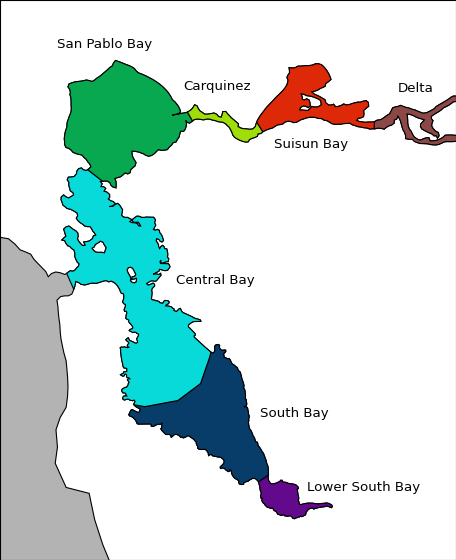

In [182]:
zoom=(533123.65957726236, 610471.18834887329, 4137693.3540862156, 4232681.5473145116)
fig=plt.figure(figsize=(5.7,7))
ax=fig.add_axes([0,0,1,1])
ax.xaxis.set_visible(0) ; ax.yaxis.set_visible(0)
grid_poly=plot_wkb.plot_polygon(grid_boundary,fc='0.7')
region_polys=[]

for poly in regions['geom']:
    gpoly=poly.intersection(grid_boundary)
    region_polys.append(  plot_wkb.plot_polygon(gpoly) )

ax.axis('equal')
ax.axis(zoom)

cmap=gmtColormap.load_gradient('oc-sst.cpt')

for ri in range(len(region_polys)):
    region_polys[ri].set_facecolor(cmap( ri/float(len(region_polys)-0.0)))
fig.savefig('regions-%s-nolabels.png'%version,dpi=200)

In [184]:
trans={'south bay':'South Bay',
       'lower south bay':'Lower South Bay',
      'central bay':'Central Bay',
      'san pablo bay':'San Pablo Bay',
      'carquinez':'Carquinez',
      'suisun bay':'Suisun Bay',
      'delta':'Delta'}
offsets={'south bay':[8e3,2e3],
         'lower south bay':[1e3,3e3],
         'central bay':[8e3,0],
         'san pablo bay':[-6e3,8e3],
         'carquinez':[-3e3,-5e3],
         'suisun bay':[-8e3,-14e3],
         'delta':[-70e3,-18e3]}
ax.texts=[]
for ri in range(len(regions)):
    name=regions[ri]['name']
    xy=np.array(regions[ri]['geom'].centroid)
    xy=xy+offsets.get(name,[0,0])
    print name,xy
    txt=trans[name]
    ax.text(xy[0],xy[1],txt)
plt.draw()
fig.savefig('regions-%s-labels.png'%version,dpi=200)

lower south bay [  585162.78999497  4149364.16741927]
south bay [  577215.40937514  4161954.30527737]
central bay [  563006.08472488  4184554.80479894]
san pablo bay [  542778.58599211  4224530.1232136 ]
carquinez [  564376.00720491  4217396.35694548]
suisun bay [  579598.58933171  4207565.42123674]
delta [  600847.46024926  4217112.86591948]
